In [ ]:
# Hyperparameter
kl_weight = 0.01

In [ ]:
## import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Optional, just for confirmation

Using device: cuda


In [ ]:
test_data_nn_pre = pd.read_csv("/content/drive/MyDrive/results/test_data_not_normalised.csv")
train_data_nn_pre = pd.read_csv("/content/drive/MyDrive/results/train_data_not_normalised.csv")

In [ ]:
train_data_nn_pre["patient_id"].unique()

array(['INH001', 'INH003', 'INH006', 'INH010', 'INH011', 'INH013',
       'INH015', 'INH017', 'INH018', 'INH024', 'INH025', 'INH028',
       'INH100', 'INH101', 'INH102', 'INH103', 'INH106', 'INH114',
       'INH110', 'INH112', 'INH113', 'INH115', 'INH117', 'INH120',
       'INH121', 'INH123', 'INH128', 'INH131', 'INH135', 'INH139'],
      dtype=object)

In [ ]:
test_data_nn_pre["patient_id"].unique()

array(['INH002', 'INH004', 'INH007', 'INH012', 'INH014', 'INH127',
       'INH023', 'INH027', 'INH107', 'INH108', 'INH109', 'INH111',
       'INH119', 'INH138'], dtype=object)

In [ ]:

# train_unique_ids = ['INH128', 'INH102', 'INH120']
# test_unique_ids = ['INH119']
train_data_nn = train_data_nn_pre.copy()
test_data_nn = test_data_nn_pre.copy()

In [ ]:
train_data_nn.columns

Index(['Unnamed: 0', 'patient_id', 'age', 'sex', 'season_x', 'br_avg',
       'br_std', 'act_level', 'step_count', 'activity', 'latitude_x',
       'longitude_x', 'season_y', 'pm2_5_x', 'temperature', 'humidity',
       'time_diff', 'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round', 'pm2_5_y', 'pm10', 'no', 'no2',
       'o3', 'so2', 'co'],
      dtype='object')

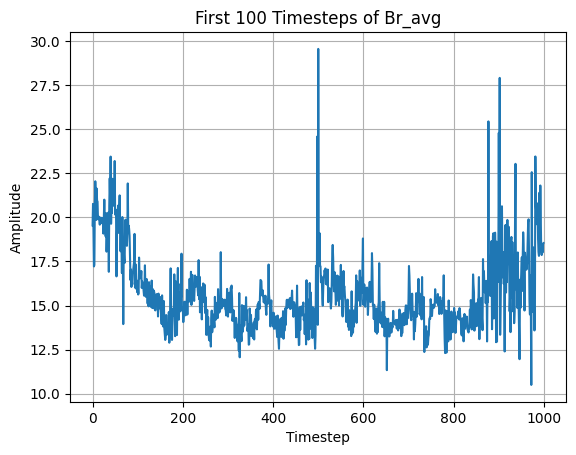

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_data_nn['br_avg'][:1000])
plt.title("First 100 Timesteps of Br_avg")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [ ]:
from torch.utils.data import Dataset, DataLoader
# ============================== DEFINING INDIVIDUAL POSITIONING WITHIN DIFFERENT BATCHES ============================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return x

# ============================== DEFINING CLASS DATASET TO HANDLE THE DATA ============================
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size=8, forecast_steps=1, step=1):
        """
        Similar to professor's concat_timesteps but as a PyTorch Dataset
        """
        self.window_size = window_size
        self.forecast_steps = forecast_steps
        self.step = step

        # Create sliding windows
        n_samples, n_features = data.shape
        num_windows = (n_samples - window_size - forecast_steps) // step + 1

        self.windows = []
        self.targets = []

        for i in range(num_windows):
            start = i * step
            window = data[start:start + window_size]
            target = data[start + window_size:start + window_size + forecast_steps]

            self.windows.append(window)
            self.targets.append(target)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = torch.FloatTensor(self.windows[idx])
        target = torch.FloatTensor(self.targets[idx])

        # For single step prediction, squeeze the target
        if self.forecast_steps == 1:
            target = target.squeeze(0)

        return window, target


In [ ]:
# ## ==================== DEFINING THE MODEL ====================

# ## For now it's a transformer Encoder Layer
# ## No decoder for now - can be added!

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math
# from torch.utils.data import Dataset, DataLoader
# import numpy as np

# class TimeSeriesTransformer(nn.Module):
#     def __init__(
#         self,
#         input_features: int = 11,  # Matching professor's 11 features
#         d_model: int = 128,
#         nhead: int = 8,
#         num_layers: int = 6,
#         dim_feedforward: int = 512,
#         dropout: float = 0.2,
#         forecast_steps: int = 1,  # Predict next timestep
#         output_features: int = 11  # Predict all features like professor's model
#     ):
#         super().__init__()

#         # Input projection (now handling all features)
#         self.input_proj = nn.Linear(input_features, d_model)

#         # Positional encoding
#         self.pos_encoder = PositionalEncoding(d_model)

#         # Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=nhead,
#             dim_feedforward=dim_feedforward,
#             dropout=dropout,
#         )
#         self.transformer_encoder = nn.TransformerEncoder(
#             encoder_layer,
#             num_layers=num_layers,
#         )

#         # Output decoder - now predicts all features
#         self.decoder = nn.Sequential(
#             nn.Linear(d_model, dim_feedforward),
#             nn.ReLU(),
#             nn.Linear(dim_feedforward, output_features * forecast_steps),
#         )

#         self.d_model = d_model
#         self.forecast_steps = forecast_steps
#         self.output_features = output_features

#     def forward(self, src: torch.Tensor) -> torch.Tensor:
#         """
#         Args:
#             src: (seq_len, batch, input_features)
#         Returns:
#             out: (batch, forecast_steps * output_features)
#         """
#         # Project and scale
#         x = self.input_proj(src) * math.sqrt(self.d_model)

#         # Add positional encoding
#         x = self.pos_encoder(x)

#         # Encode
#         enc_out = self.transformer_encoder(x)  # (seq_len, batch, d_model)

#         # Take last time-step
#         last = enc_out[-1, :, :]  # (batch, d_model)

#         # Predict all features
#         out = self.decoder(last)  # (batch, forecast_steps * output_features)

#         # Reshape if forecasting multiple steps
#         if self.forecast_steps > 1:
#             out = out.view(-1, self.forecast_steps, self.output_features)

#         return out


In [ ]:
# class VariationalTimeSeriesTransformer(nn.Module):
#     def __init__(
#         self,
#         input_features: int = 11,
#         d_model: int = 128,
#         latent_dim: int = 64,  # New: Latent dimension
#         nhead: int = 8,
#         num_layers: int = 6,
#         dim_feedforward: int = 512,
#         dropout: float = 0.2,
#         forecast_steps: int = 1,
#         output_features: int = 11
#     ):
#         super().__init__()

#         self.input_proj = nn.Linear(input_features, d_model)
#         self.pos_encoder = PositionalEncoding(d_model)

#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=nhead,
#             dim_feedforward=dim_feedforward,
#             dropout=dropout,
#         )
#         self.transformer_encoder = nn.TransformerEncoder(
#             encoder_layer,
#             num_layers=num_layers,
#         )

#         # Latent projection
#         self.mean_layer = nn.Linear(d_model, latent_dim)
#         self.logvar_layer = nn.Linear(d_model, latent_dim)

#         # Decoder maps from latent space → forecast
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, dim_feedforward),
#             nn.ReLU(),
#             nn.Linear(dim_feedforward, output_features * forecast_steps),
#         )

#         self.d_model = d_model
#         self.latent_dim = latent_dim
#         self.forecast_steps = forecast_steps
#         self.output_features = output_features

#     def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, src: torch.Tensor):
#         """
#         Args:
#             src: (seq_len, batch, input_features)
#         Returns:
#             recon: (batch, forecast_steps, output_features)
#             mu: (batch, latent_dim)
#             logvar: (batch, latent_dim)
#         """
#         x = self.input_proj(src) * math.sqrt(self.d_model)
#         x = self.pos_encoder(x)

#         enc_out = self.transformer_encoder(x)  # (seq_len, batch, d_model)

#         # Take last time-step
#         last = enc_out[-1, :, :]  # (batch, d_model)

#         # Latent space
#         mu = self.mean_layer(last)      # (batch, latent_dim)
#         logvar = self.logvar_layer(last)  # (batch, latent_dim)

#         # Sample from latent distribution
#         z = self.reparameterize(mu, logvar)  # (batch, latent_dim)

#         # Decode
#         recon = self.decoder(z)  # (batch, forecast_steps * output_features)

#         if self.forecast_steps > 1:
#             recon = recon.view(-1, self.forecast_steps, self.output_features)

#         return recon, mu, logvar


# ## Defining loss function here

# def vae_loss(recon, target, mu, logvar, kl_weight=kl_weight):

#     recon_loss = F.mse_loss(recon, target, reduction='mean')

#     kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#     total_loss = recon_loss + kl_weight * kl_loss

#     return total_loss, recon_loss, kl_loss




In [ ]:
class HierarchicalVariationalTimeSeriesTransformer(nn.Module):
    def __init__(self, input_features=11, d_model=128, latent_dim=32, num_segments=4,
                 nhead=8, num_layers=6, dim_feedforward=512, dropout=0.2,
                 forecast_steps=1, output_features=11):
        super().__init__()

        self.num_segments = num_segments
        self.input_proj = nn.Linear(input_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Hierarchical latent heads
        self.mean_layer = nn.Linear(d_model, latent_dim)
        self.logvar_layer = nn.Linear(d_model, latent_dim)

        # Global latent (optional)
        self.global_mean = nn.Linear(d_model, latent_dim)
        self.global_logvar = nn.Linear(d_model, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim * (num_segments + 1), dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_features * forecast_steps),
        )

        self.d_model = d_model
        self.latent_dim = latent_dim
        self.forecast_steps = forecast_steps
        self.output_features = output_features

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, src):
        """
        Args:
            src: (seq_len, batch, input_features)
        Returns:
            recon: (batch, forecast_steps, output_features)
            mu_list: List of (batch, latent_dim)
            logvar_list: List of (batch, latent_dim)
        """
        x = self.input_proj(src) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        enc_out = self.transformer_encoder(x)  # (seq_len, batch, d_model)

        seq_len = enc_out.size(0)
        seg_len = seq_len // self.num_segments

        mu_list, logvar_list, z_list = [], [], []

        for i in range(self.num_segments):
            segment = enc_out[i * seg_len:(i + 1) * seg_len, :, :]  # (seg_len, batch, d_model)
            pooled = segment.mean(dim=0)  # (batch, d_model)
            mu = self.mean_layer(pooled)
            logvar = self.logvar_layer(pooled)
            z = self.reparameterize(mu, logvar)
            mu_list.append(mu)
            logvar_list.append(logvar)
            z_list.append(z)

        # Optional global latent
        global_pooled = enc_out.mean(dim=0)  # (batch, d_model)
        mu_g = self.global_mean(global_pooled)
        logvar_g = self.global_logvar(global_pooled)
        z_global = self.reparameterize(mu_g, logvar_g)

        mu_list.append(mu_g)
        logvar_list.append(logvar_g)
        z_list.append(z_global)

        # Concatenate all z's: (batch, latent_dim * (num_segments + 1))
        z_combined = torch.cat(z_list, dim=1)

        recon = self.decoder(z_combined)  # (batch, forecast_steps * output_features)
        if self.forecast_steps > 1:
            recon = recon.view(-1, self.forecast_steps, self.output_features)

        return recon, mu_list, logvar_list

def hierarchical_vae_loss(recon, target, mu_list, logvar_list, kl_weight=1.0):
    recon_loss = F.mse_loss(recon, target, reduction='mean')
    kl_loss = 0.0
    for mu, logvar in zip(mu_list, logvar_list):
        kl_loss += -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss, kl_loss


In [ ]:
## ====================== TRAINING AND EVALUATING THE MODEL =======================
import torch.nn.functional as F

def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    epochs=30,
    patience=5,
    min_delta=1e-4,
    kl_weight=kl_weight
):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0.0

        for inputs, targets in train_loader:
            # inputs: (batch, window_size, features)
            # targets: (batch, features) or (batch, forecast_steps, features)

            inputs = inputs.permute(1, 0, 2).to(device)  # (window_size, batch, features)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs, mu, logvar = model(inputs)

            # Calculate loss
            if model.forecast_steps > 1:
                # For multi-step, reshape outputs to match targets
                outputs = outputs.view(targets.shape[0], targets.shape[1], targets.shape[2])

            loss, recon_loss, kl_loss = hierarchical_vae_loss(outputs, targets, mu, logvar, kl_weight)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0
        total_val_kl = 0.0
        total_val_recon = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.permute(1, 0, 2).to(device)
                targets = targets.to(device)

                outputs, mu, logvar = model(inputs)

                if model.forecast_steps > 1:
                    outputs = outputs.view(targets.shape[0], targets.shape[1], targets.shape[2])

                val_loss, val_recon, val_kl = hierarchical_vae_loss(outputs, targets, mu, logvar, kl_weight)
                total_val_loss += val_loss.item()
                total_val_recon += val_recon.item()
                total_val_kl += val_kl.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_recon = total_val_recon / len(val_loader)
        avg_val_kl = total_val_kl / len(val_loader)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

        # Early Stopping
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch} - Best Val Loss: {best_val_loss:.6f}")
                break

In [ ]:
train_data_nn_pre.columns

Index(['Unnamed: 0', 'patient_id', 'age', 'sex', 'season_x', 'br_avg',
       'br_std', 'act_level', 'step_count', 'activity', 'latitude_x',
       'longitude_x', 'season_y', 'pm2_5_x', 'temperature', 'humidity',
       'time_diff', 'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round', 'pm2_5_y', 'pm10', 'no', 'no2',
       'o3', 'so2', 'co'],
      dtype='object')

In [ ]:
## Useful to filter down!

print(train_data_nn_pre["patient_id"].unique(), test_data_nn_pre["patient_id"].unique())
print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()))

train_data_nn_pre = train_data_nn_pre[train_data_nn_pre["patient_id"].isin(['INH001','INH003', 'INH006', 'INH106' ,'INH114' ,'INH110'])]
test_data_nn_pre = test_data_nn_pre[test_data_nn_pre["patient_id"].isin(['INH012','INH014','INH107' ])]

print(train_data_nn_pre["patient_id"].unique(), test_data_nn_pre["patient_id"].unique())
print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()))

['INH001' 'INH003' 'INH006' 'INH010' 'INH011' 'INH013' 'INH015' 'INH017'
 'INH018' 'INH024' 'INH025' 'INH028' 'INH100' 'INH101' 'INH102' 'INH103'
 'INH106' 'INH114' 'INH110' 'INH112' 'INH113' 'INH115' 'INH117' 'INH120'
 'INH121' 'INH123' 'INH128' 'INH131' 'INH135' 'INH139'] ['INH002' 'INH004' 'INH007' 'INH012' 'INH014' 'INH127' 'INH023' 'INH027'
 'INH107' 'INH108' 'INH109' 'INH111' 'INH119' 'INH138']
30 14
['INH001' 'INH003' 'INH006' 'INH106' 'INH114' 'INH110'] ['INH012' 'INH014' 'INH107']
6 3


In [ ]:
train_data_nn_pre.columns

Index(['Unnamed: 0', 'patient_id', 'age', 'sex', 'season_x', 'br_avg',
       'br_std', 'act_level', 'step_count', 'activity', 'latitude_x',
       'longitude_x', 'season_y', 'pm2_5_x', 'temperature', 'humidity',
       'time_diff', 'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round', 'pm2_5_y', 'pm10', 'no', 'no2',
       'o3', 'so2', 'co'],
      dtype='object')

In [ ]:
## ================= INSTANTIATING AND CALLING THE MODEL ==================

# Hyperparameters
window_size = 8
forecast_steps = 1
batch_size = 32
d_model = 128
nhead = 8
num_layers = 6
dim_feedforward = 512
dropout = 0.2
lr = 1e-3
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_train = train_data_nn_pre.copy()
data_test = test_data_nn_pre.copy()

# Transform numerical columns
# feature_cols = ['pm2_5_x', 'pm10', 'temperature', 'humidity',
#                 'br_avg', 'br_std', 'act_level', 'step_count',
#                 'hour_sin', 'hour_cos']

feature_cols = ['br_avg', 'br_std', 'act_level', 'step_count','pm2_5_x', 'temperature', 'humidity', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round','pm10', 'no', 'no2',
       'o3', 'so2', 'co']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train[feature_cols])

train_data = scaler.transform(data_train[feature_cols])
test_data = scaler.transform(data_test[feature_cols])

# Create datasets
train_dataset = SlidingWindowDataset(train_data, window_size, forecast_steps)
test_dataset = SlidingWindowDataset(test_data, window_size, forecast_steps)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = HierarchicalVariationalTimeSeriesTransformer(
    input_features=len(feature_cols),
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    forecast_steps=forecast_steps,
    output_features=len(feature_cols)
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/3 - Train Loss: 0.015271 - Val Loss: 0.015153
Epoch 2/3 - Train Loss: 0.010287 - Val Loss: 0.013380
Epoch 3/3 - Train Loss: 0.009327 - Val Loss: 0.012645


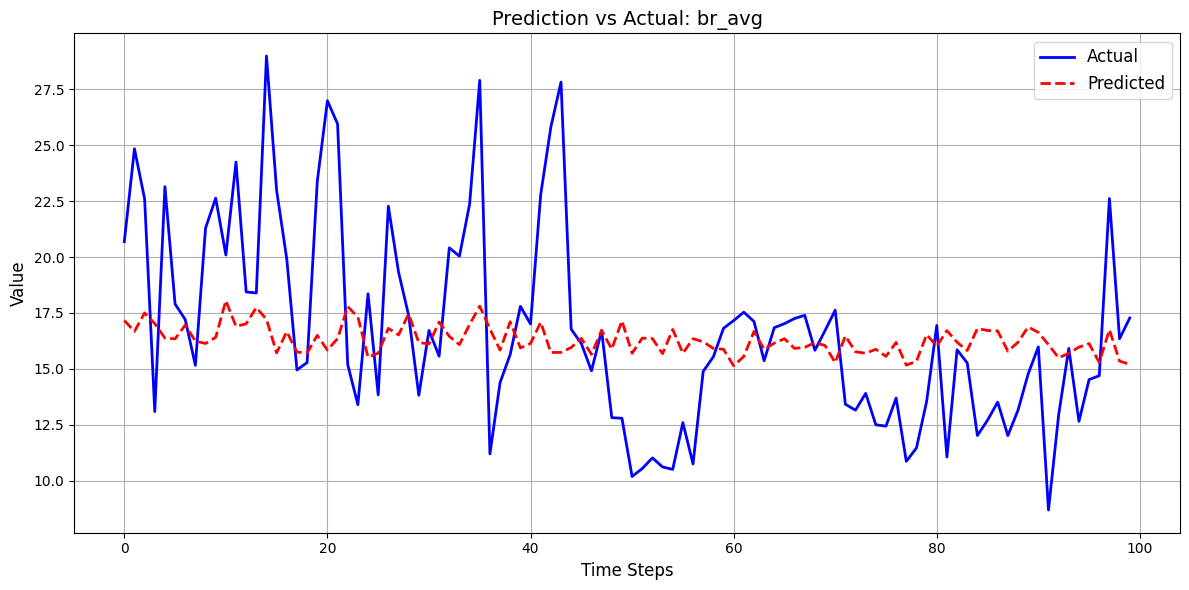

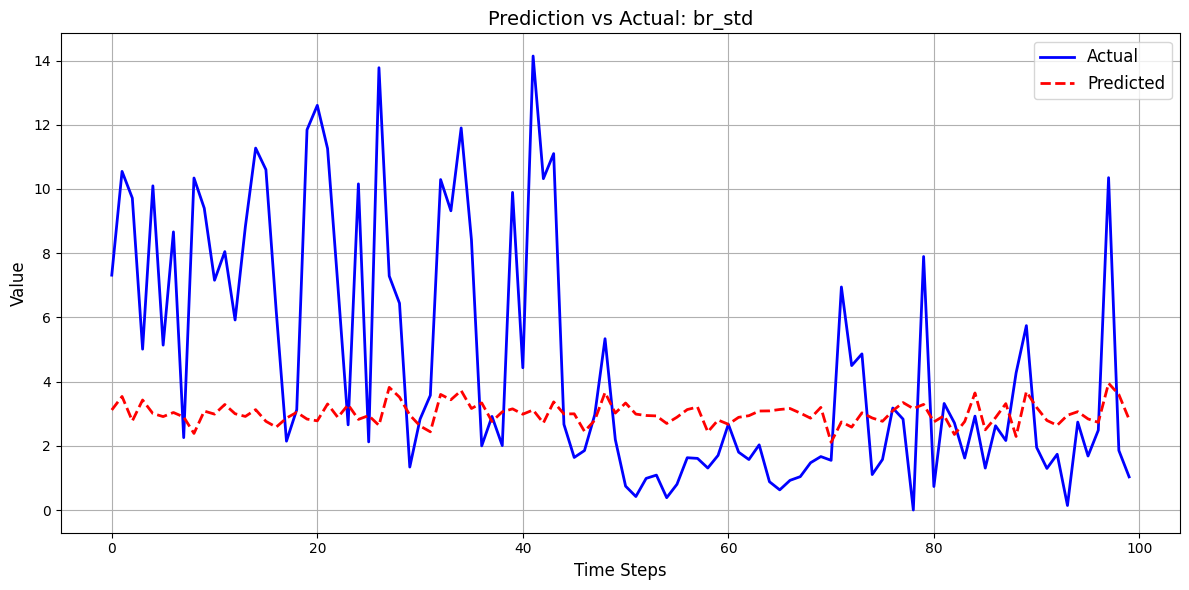

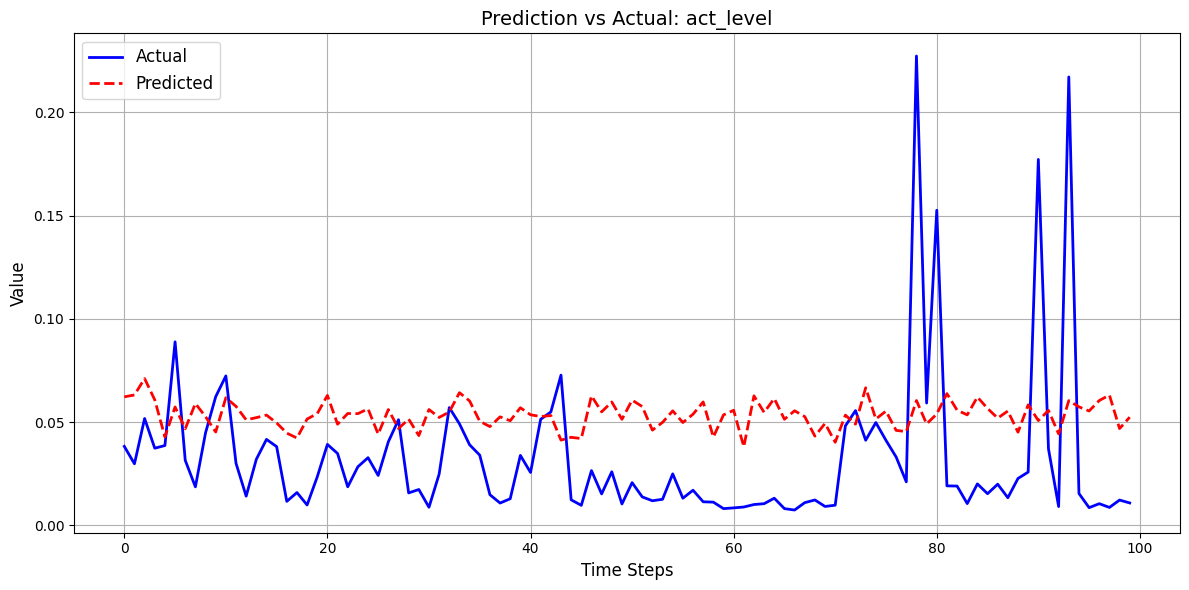

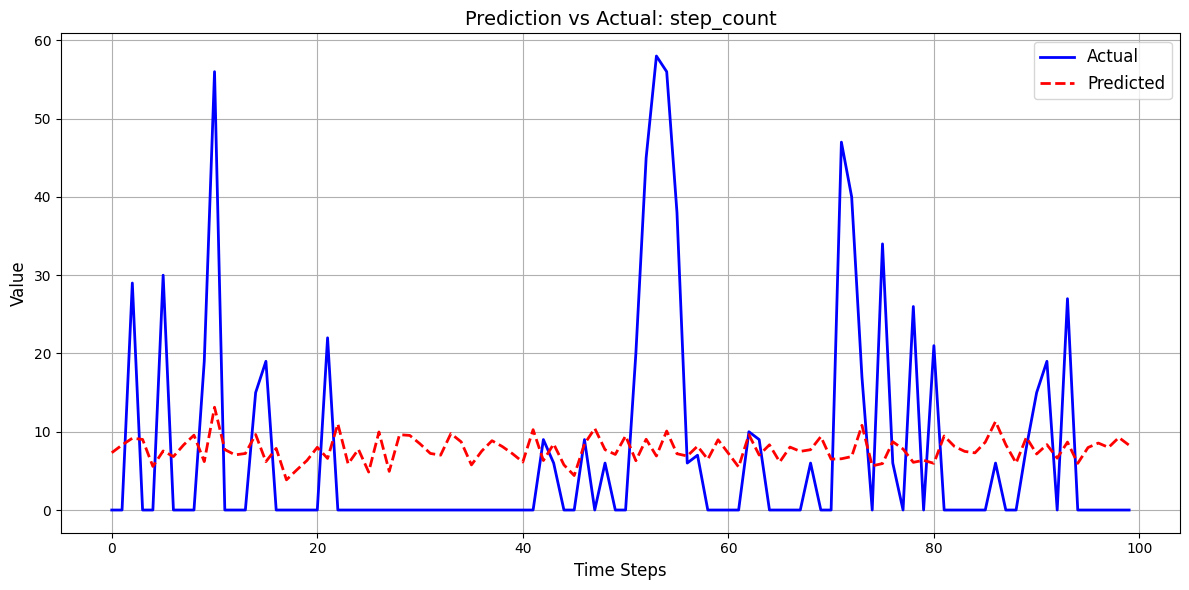

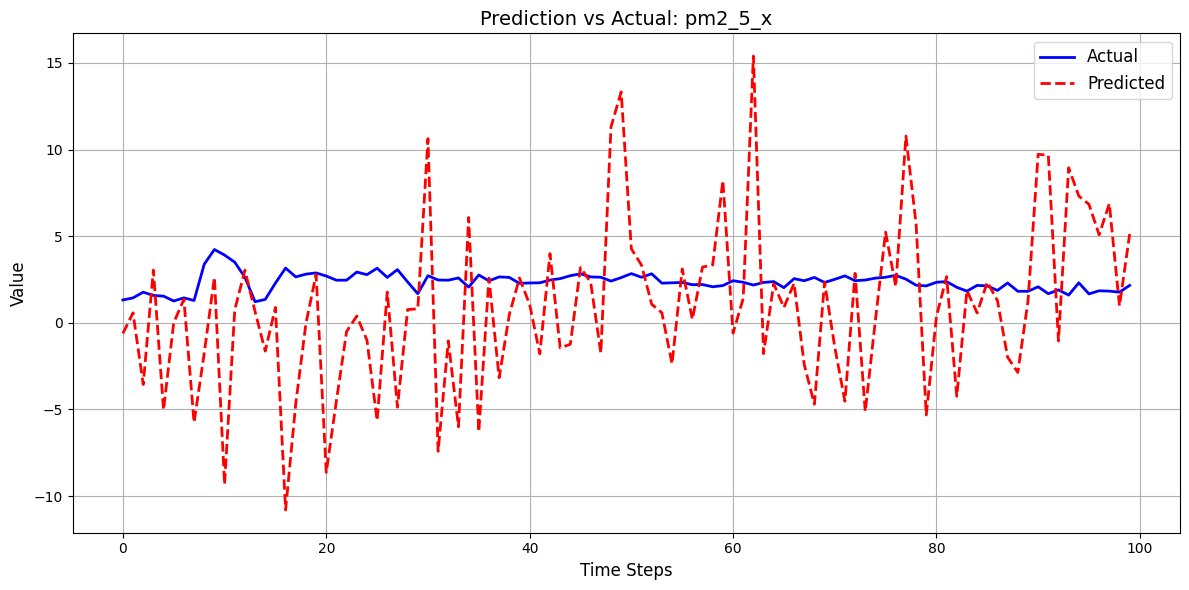

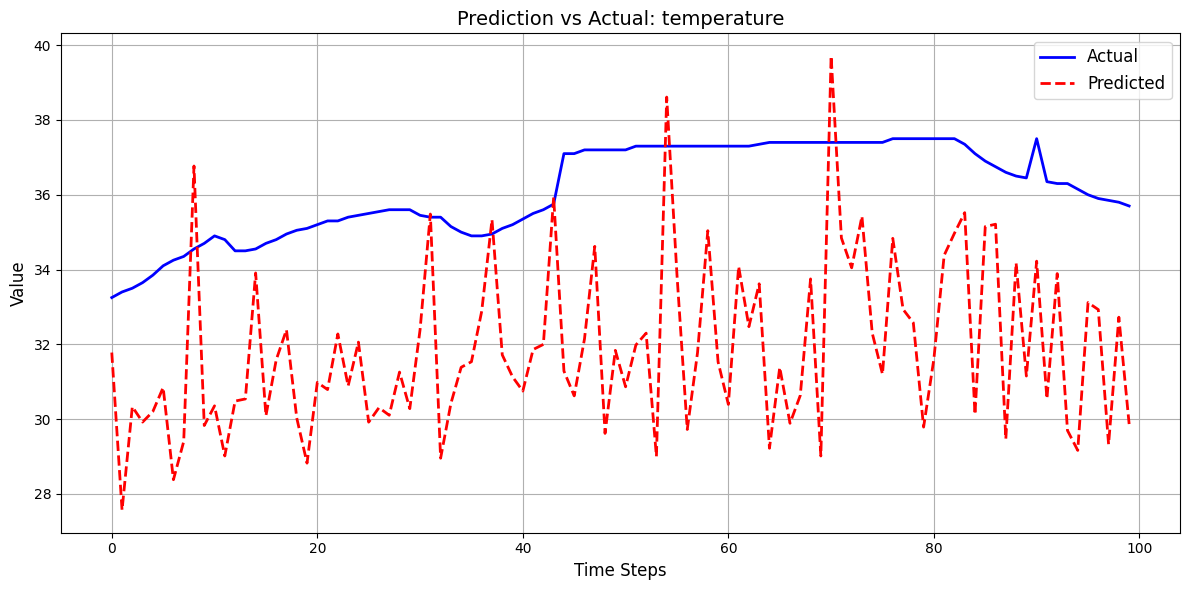

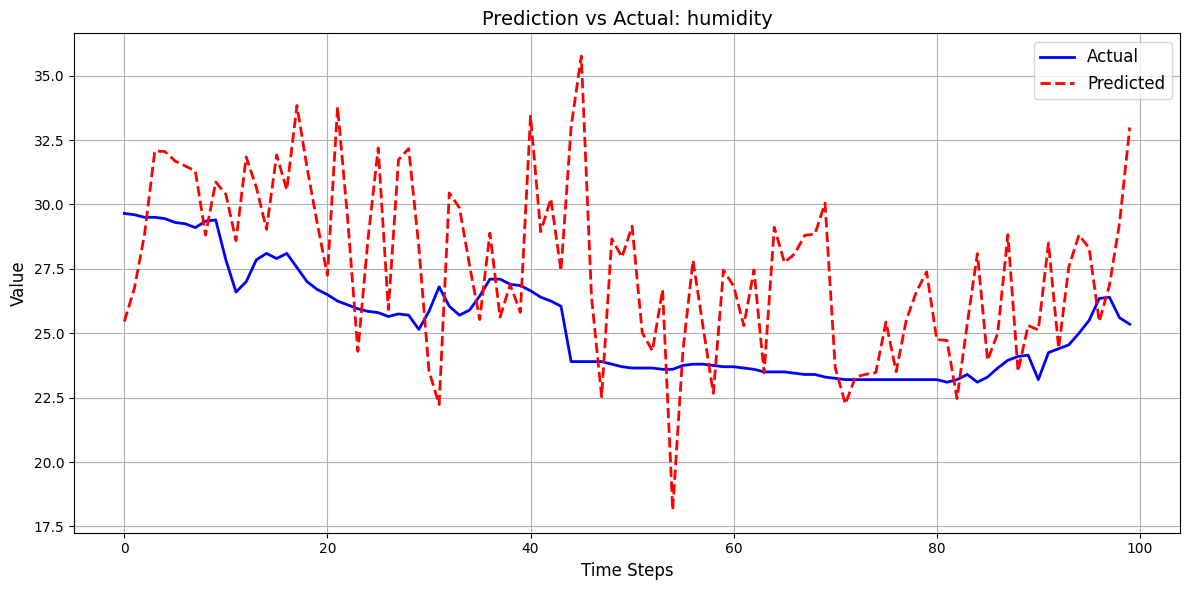

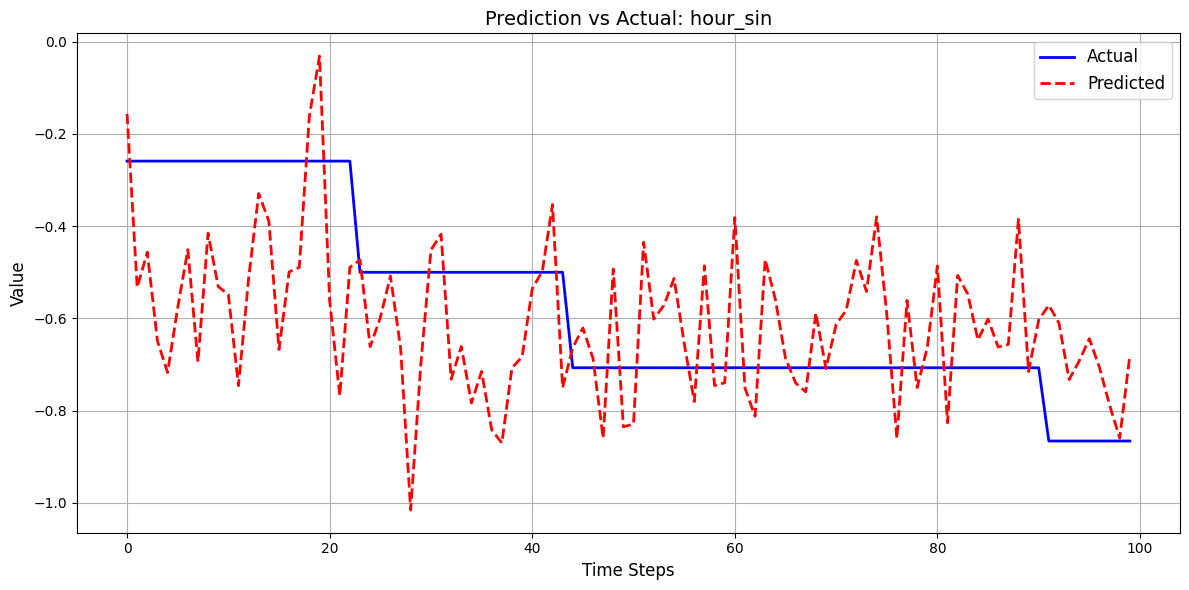

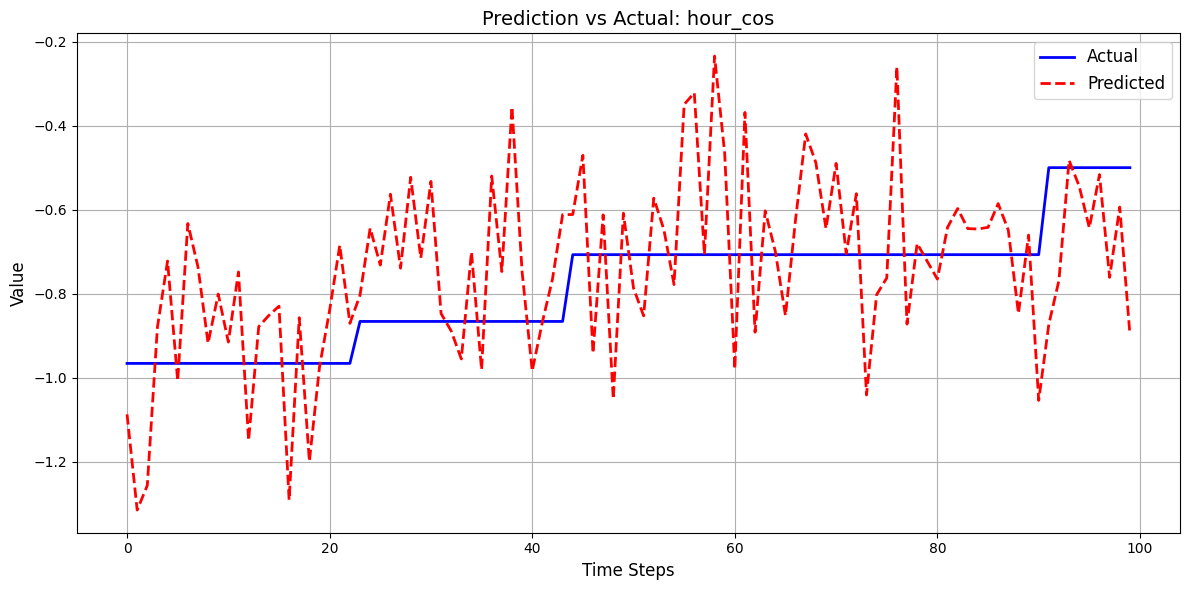

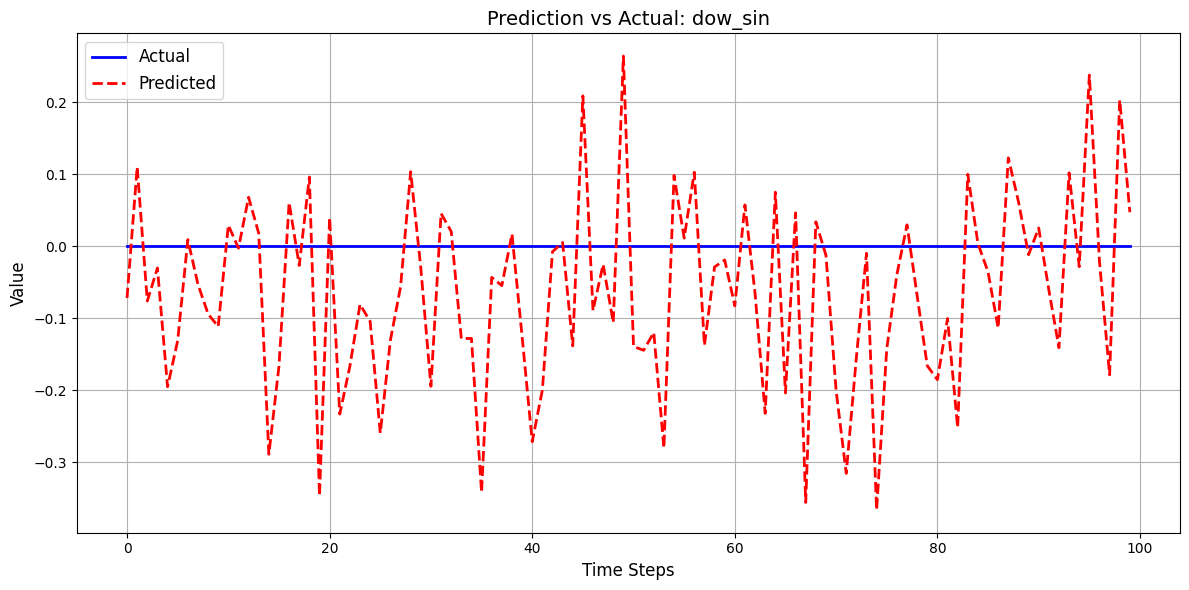

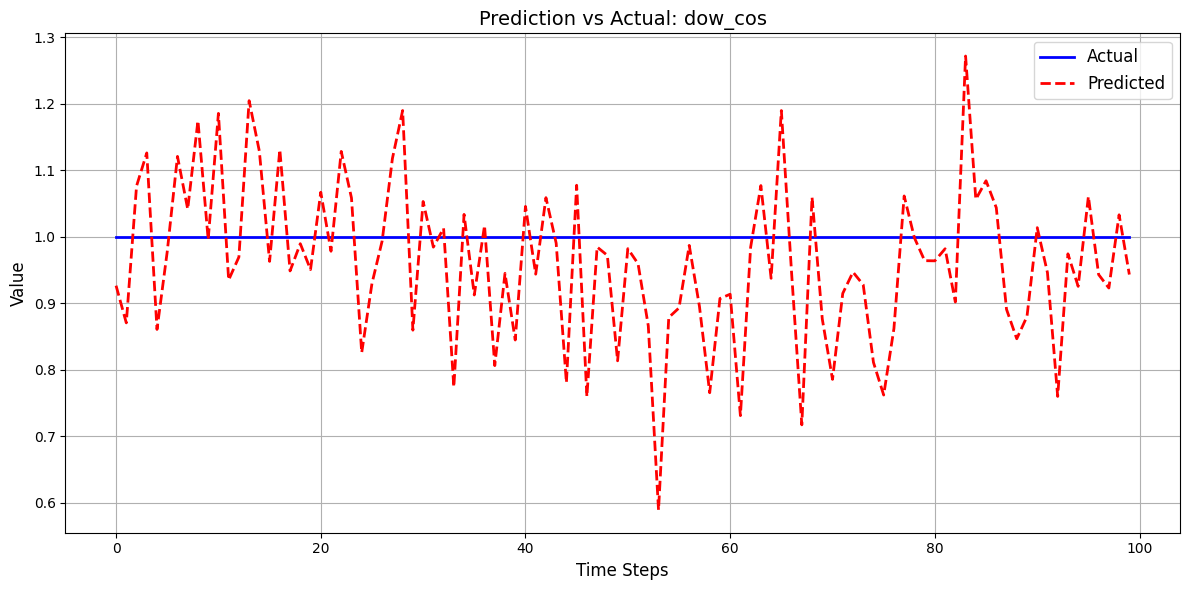

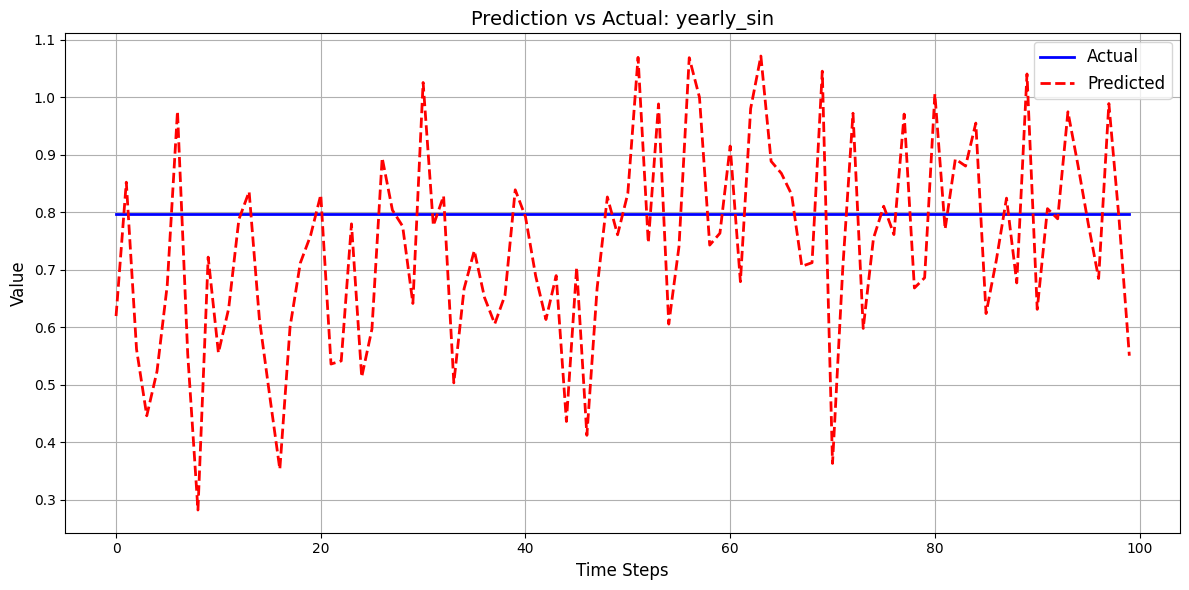

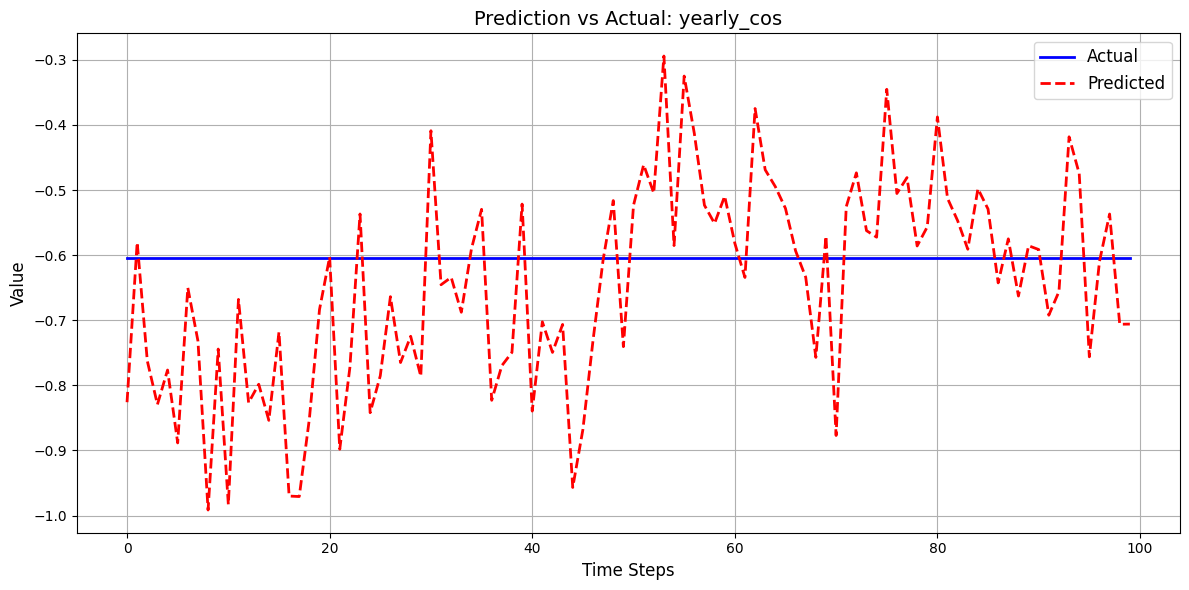

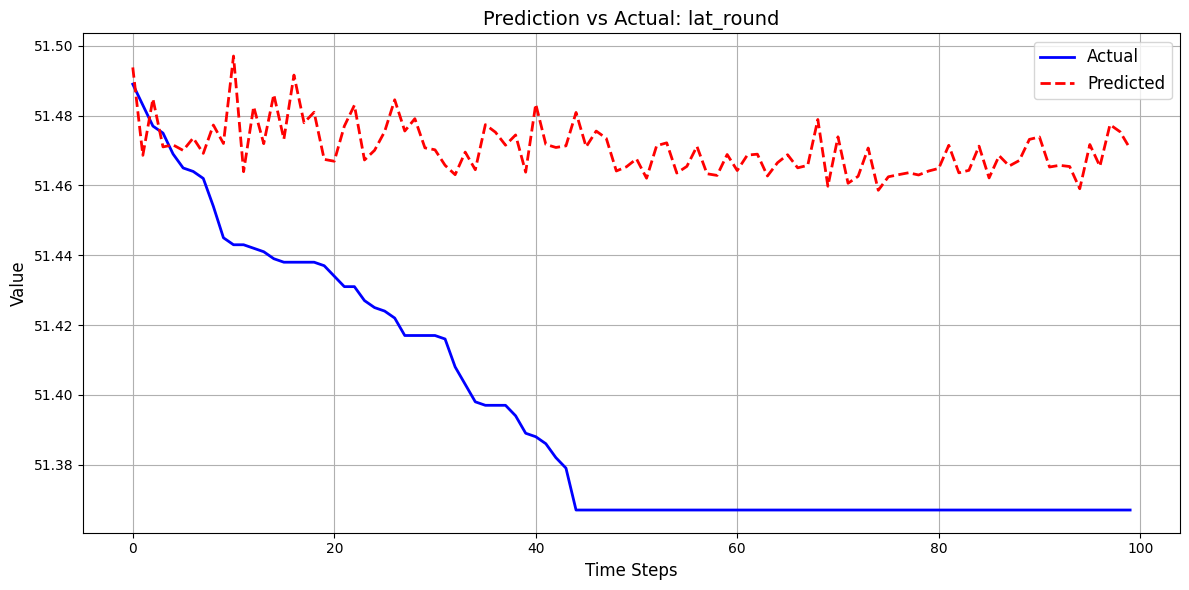

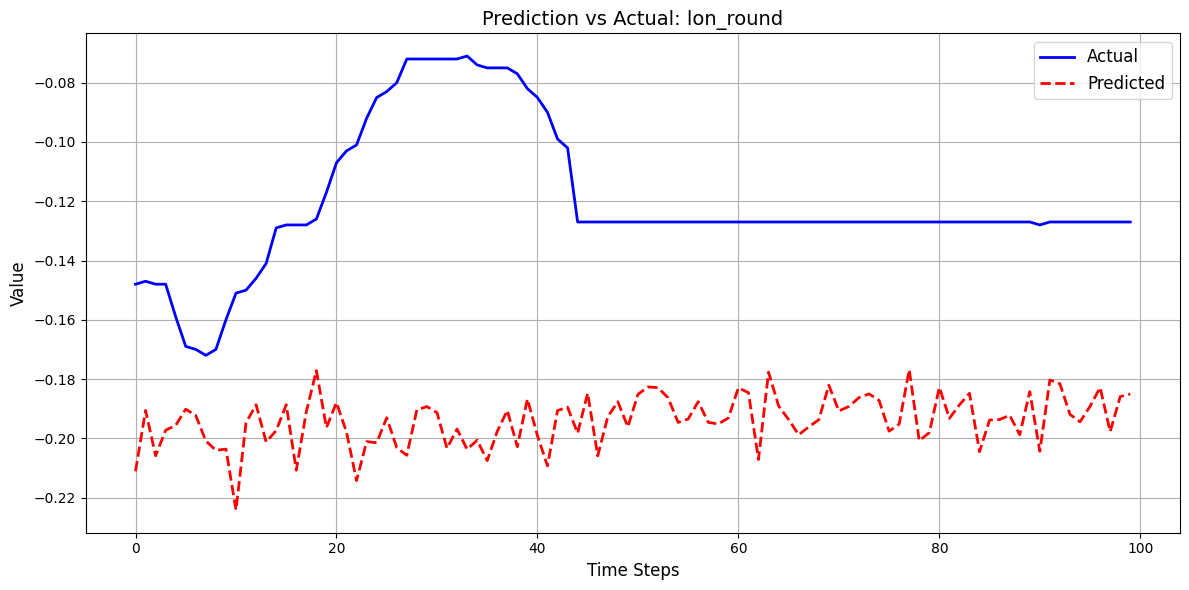

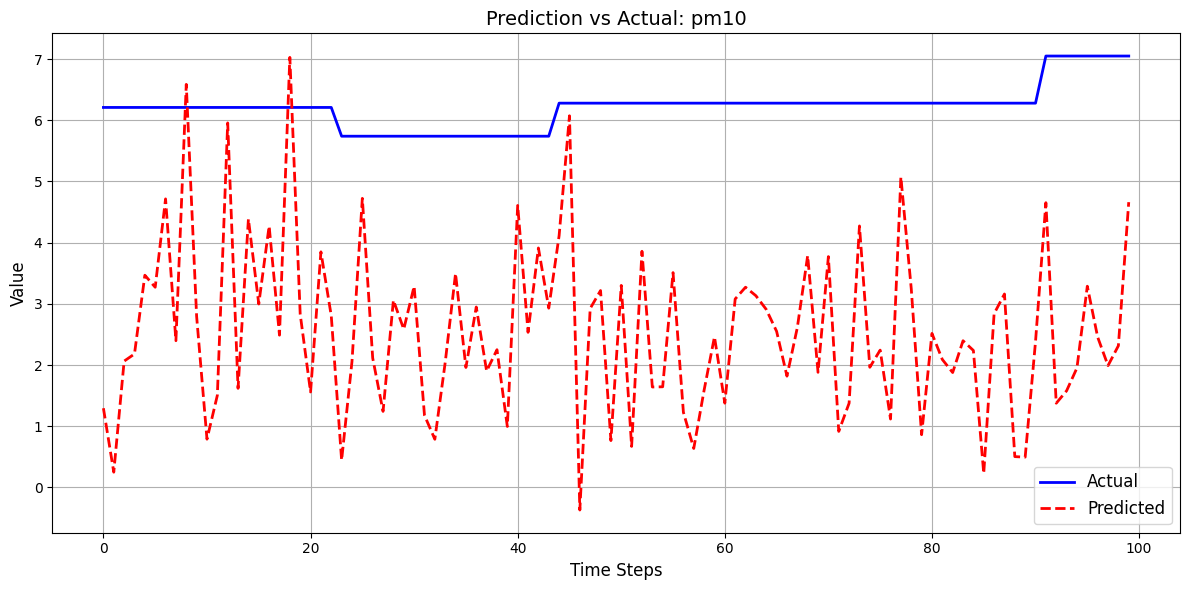

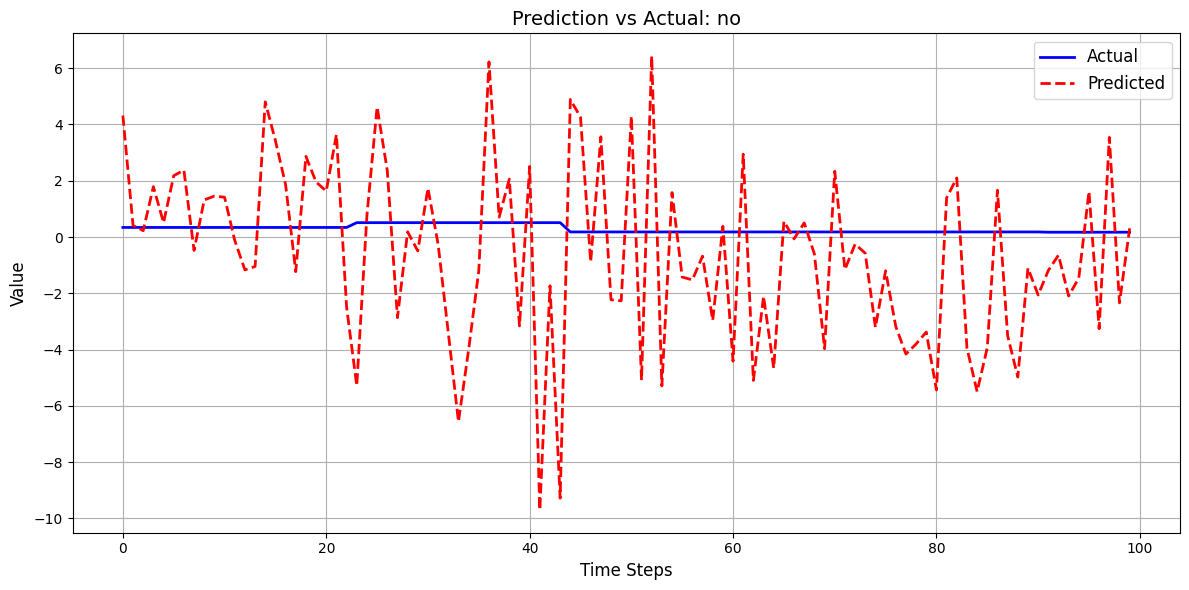

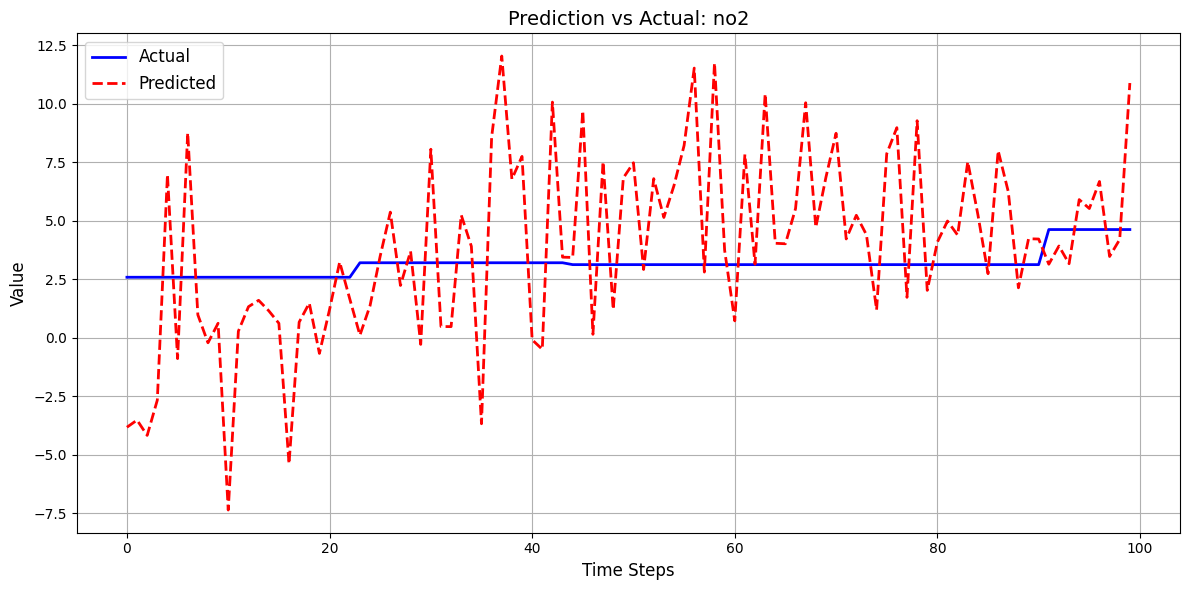

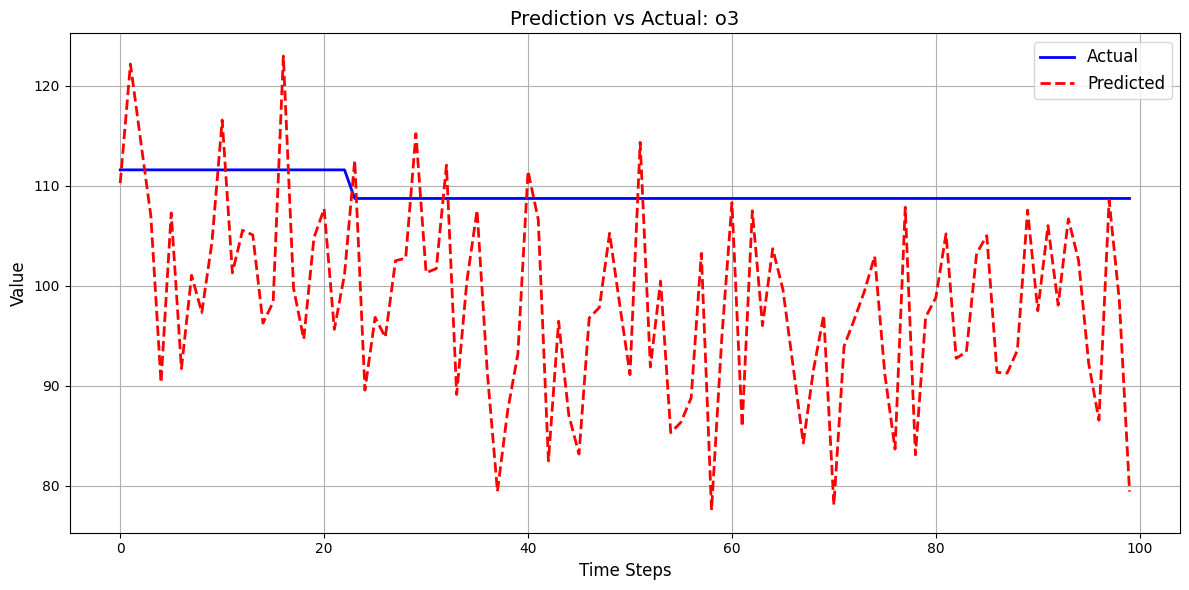

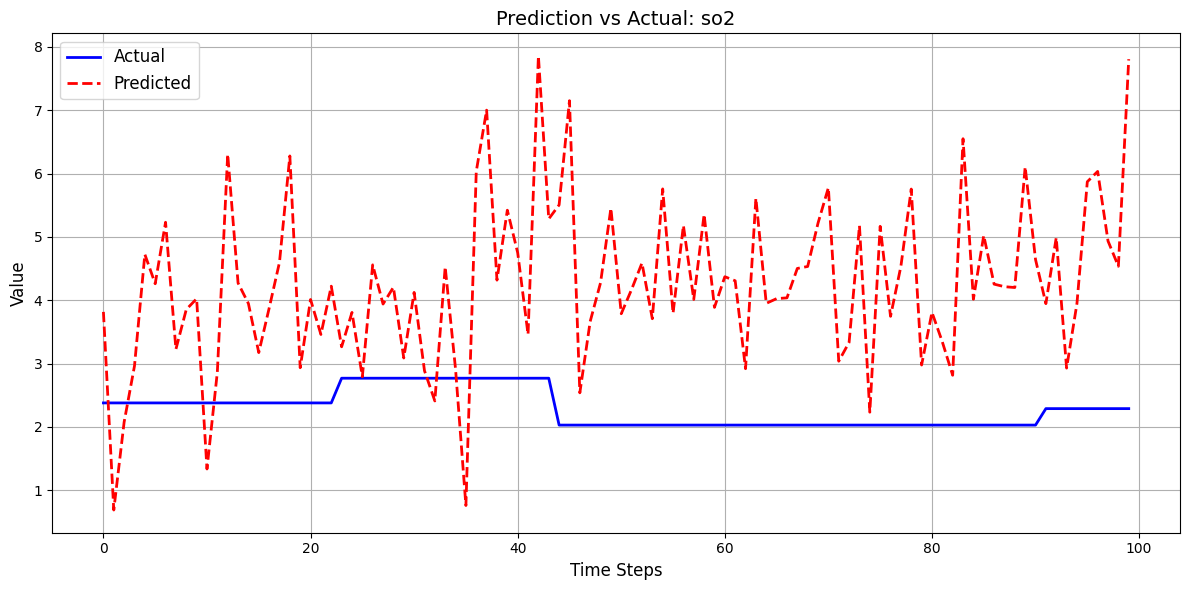

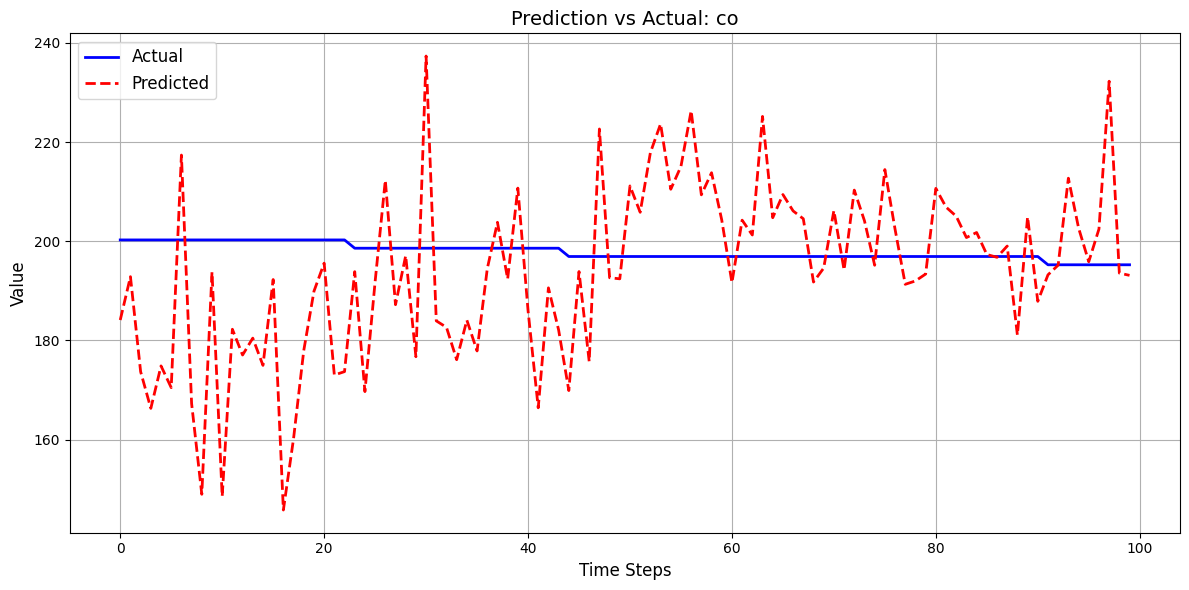


Overall Metrics:
MSE: 135.1640
MAE: 3.9401
R² Score: 0.4676

Per-feature Metrics:
br_avg:
  MSE: 8.9513, MAE: 2.3517, R²: -0.2672
br_std:
  MSE: 2.9855, MAE: 1.2672, R²: 0.1553
act_level:
  MSE: 0.0012, MAE: 0.0194, R²: 0.1209
step_count:
  MSE: 151.9153, MAE: 5.3720, R²: -0.0038
pm2_5_x:
  MSE: 315.5549, MAE: 8.5174, R²: -0.3816
temperature:
  MSE: 7.7126, MAE: 2.1267, R²: 0.3392
humidity:
  MSE: 18.8570, MAE: 3.3873, R²: 0.5619
hour_sin:
  MSE: 0.0339, MAE: 0.1389, R²: 0.9190
hour_cos:
  MSE: 0.0435, MAE: 0.1516, R²: 0.9179
dow_sin:
  MSE: 0.0211, MAE: 0.1094, R²: 0.9565
dow_cos:
  MSE: 0.0228, MAE: 0.1107, R²: 0.9552
yearly_sin:
  MSE: 0.0204, MAE: 0.1088, R²: 0.9554
yearly_cos:
  MSE: 0.0192, MAE: 0.1073, R²: 0.9505
lat_round:
  MSE: 0.0044, MAE: 0.0504, R²: -1.1099
lon_round:
  MSE: 0.0032, MAE: 0.0422, R²: -0.0085
pm10:
  MSE: 44.6006, MAE: 4.6006, R²: 0.6485
no:
  MSE: 206.8048, MAE: 7.2700, R²: 0.8393
no2:
  MSE: 55.9151, MAE: 5.4032, R²: 0.8518
o3:
  MSE: 191.7994, MAE: 10.82

In [ ]:
def evaluate_model(model, dataloader, device, scaler=None, feature_names=None):
    """
    Evaluate the model and plot predictions vs actual values for all features
    Similar to professor's plotting code but adapted for transformer

    Args:
        model: Trained model
        dataloader: DataLoader with test data
        device: torch device
        scaler: Optional scaler for inverse transformation
        feature_names: List of feature names for plotting
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)
            outputs, mu, logvar = model(inputs)

            # Store predictions and targets
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Concatenate all batches
    preds = np.concatenate(all_preds, axis=0)
    trues = np.concatenate(all_targets, axis=0)

    # If we predicted multiple steps, average them for visualization
    if preds.ndim == 3:  # (samples, forecast_steps, features)
        preds = preds.mean(axis=1)  # Average across forecast steps
        trues = trues.mean(axis=1)

    # Inverse transform if scaler is provided
    if scaler is not None:
        # Need to create dummy arrays with same shape as original data
        dummy_cols = scaler.n_features_in_

        # Create containers for inverse transform
        preds_full = np.zeros((len(preds), dummy_cols))
        trues_full = np.zeros((len(trues), dummy_cols))

        # Only fill the columns we predicted
        preds_full[:, :preds.shape[1]] = preds
        trues_full[:, :trues.shape[1]] = trues

        # Inverse transform
        preds = scaler.inverse_transform(preds_full)[:, :preds.shape[1]]
        trues = scaler.inverse_transform(trues_full)[:, :trues.shape[1]]

    # Plot each feature separately
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(preds.shape[1])]

    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(12, 6))

        # Plot first 100 samples for clarity
        plt.plot(trues[:100, i], 'b-', label='Actual', linewidth=2)
        plt.plot(preds[:100, i], 'r--', label='Predicted', linewidth=2)

        plt.title(f'Prediction vs Actual: {feature}', fontsize=14)
        plt.xlabel('Time Steps', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return preds, trues

# Define feature names (should match your dataset)
# feature_names = ['pm1', 'pm2_5', 'pm10', 'temperature', 'humidity',
#                 'br_avg', 'br_std', 'act_level', 'step_count',
#                 'hour_sin', 'hour_cos']

feature_names = feature_cols
# Evaluate and plot
preds, trues = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device,
    scaler=scaler,
    feature_names=feature_names
)

# Additional metrics calculation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\nOverall Metrics:")
print(f"MSE: {mean_squared_error(trues, preds):.4f}")
print(f"MAE: {mean_absolute_error(trues, preds):.4f}")
print(f"R² Score: {r2_score(trues, preds):.4f}")

# Per-feature metrics
print("\nPer-feature Metrics:")
for i, feature in enumerate(feature_names):
    mse = mean_squared_error(trues[:, i], preds[:, i])
    mae = mean_absolute_error(trues[:, i], preds[:, i])
    r2 = r2_score(trues[:, i], preds[:, i])

    print(f"{feature}:")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

In [ ]:
ciao

NameError: name 'ciao' is not defined

## Appendix

## DATASET AND DATALOADER

In [ ]:
# from torch.utils.data import Dataset
# import torch

# class PatientSegmentForecastDataset(Dataset):
#     def __init__(self, dataframe, seq_len=50, forecast_steps=10, stride=1):
#         """
#         Args:
#             dataframe (pd.DataFrame): The entire dataset containing preprocessed segments
#             seq_len (int): Length of the input sequence
#             forecast_steps (int): Length of the forecast horizon
#             stride (int): Window stride for moving through each segment
#         """
#         self.seq_len = seq_len
#         self.forecast_steps = forecast_steps
#         self.stride = stride
#         self.sequences = []

#         # Feature columns: exclude ID columns
#         feature_cols = [col for col in dataframe.columns if col not in ['patient_id', 'segment_id']]

#         # Group by (patient_id, segment_id)
#         grouped = dataframe.groupby(['patient_id', 'segment_id'])

#         for (pid, sid), group in grouped:
#             group = group[feature_cols].reset_index(drop=True)
#             data_tensor = torch.tensor(group.values, dtype=torch.float32)

#             total_len = data_tensor.shape[0]
#             if total_len < seq_len + forecast_steps:
#                 continue  # Not enough data

#             num_windows = (total_len - (seq_len + forecast_steps)) // stride + 1
#             for i in range(num_windows):
#                 start = i * stride
#                 end = start + seq_len + forecast_steps
#                 window = data_tensor[start:end]
#                 input_seq = window[:seq_len]
#                 target_seq = window[seq_len:]
#                 self.sequences.append((input_seq, target_seq))

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         return self.sequences[idx]


In [ ]:
# import numpy as np
# import torch
# from torch.utils.data import DataLoader


# seq_len = 50
# forecast_steps = 60
# stride = 10
# batch_size = 64

# train_dataset = PatientSegmentForecastDataset(train_df_scaled, seq_len, forecast_steps, stride)
# test_dataset = PatientSegmentForecastDataset(test_df_scaled, seq_len, forecast_steps, stride)

# from torch.utils.data import DataLoader

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# # Get one batch from train_loader
# train_batch = next(iter(train_loader))
# input_seq, future_seq = train_batch

# print("=== Train Loader Sample ===")
# print(f"Input sequence shape: {input_seq.shape}")       # (batch_size, seq_len, num_features)
# print(f"Future sequence shape: {future_seq.shape}")     # (batch_size, forecast_steps, num_features)

# # Same for val_loader
# val_batch = next(iter(val_loader))
# input_seq_val, future_seq_val = val_batch

# print("\n=== Val Loader Sample ===")
# print(f"Input sequence shape: {input_seq_val.shape}")
# print(f"Future sequence shape: {future_seq_val.shape}")


In [ ]:
# print(len(train_dataset))  # Should be > 0
# print(len(test_dataset))   # Likely 0 in your case

## VARIATIONAL ENCODER DECODER FOR TIMESERIES FORECASTING

## DEFINING THE MODEL

## For now we use Sequential:
- When it works we will change it to a proper transformer


In [ ]:
# import torch
# import torch.nn as nn
# import math
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# # === Positional Encoding ===
# class PositionalEncoding(nn.Module):
#     """
#     Implements the standard sinusoidal positional encoding.
#     """
#     def __init__(self, d_model, max_len=200):
#         super().__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, d_model, 2, dtype=torch.float) *
#             (-math.log(10000.0) / d_model)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
#         self.register_buffer('pe', pe)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # x shape: (seq_len, batch, d_model)
#         x = x + self.pe[:x.size(0)]
#         return x


# # === TimeSeries Transformer ===
# class TimeSeriesTransformer(nn.Module):
#     def __init__(
#         self,
#         feature_size: int,
#         d_model: int = 64,
#         nhead: int = 8,
#         num_layers: int = 3,
#         dim_feedforward: int = 128,
#         dropout: float = 0.1,
#         forecast_steps: int = 10,
#     ):
#         super().__init__()
#         # project input features to model dimension
#         self.input_proj = nn.Linear(feature_size, d_model)
#         # positional encoding
#         self.pos_encoder = PositionalEncoding(d_model)
#         # transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=nhead,
#             dim_feedforward=dim_feedforward,
#             dropout=dropout,
#         )
#         self.transformer_encoder = nn.TransformerEncoder(
#             encoder_layer,
#             num_layers=num_layers,
#         )
#         # output decoder: mapping last hidden to forecast steps
#         self.decoder = nn.Linear(d_model, forecast_steps)
#         self.d_model = d_model

#     def forward(self, src: torch.Tensor) -> torch.Tensor:
#         """
#         Args:
#             src: (seq_len, batch, feature_size)
#         Returns:
#             out: (batch, forecast_steps)
#         """
#         # project and scale
#         x = self.input_proj(src) * math.sqrt(self.d_model)
#         # add positional encoding
#         x = self.pos_encoder(x)
#         # encode
#         enc_out = self.transformer_encoder(x)  # (seq_len, batch, d_model)
#         # take last time-step
#         last = enc_out[-1, :, :]               # (batch, d_model)
#         # predict
#         out = self.decoder(last)               # (batch, forecast_steps)
#         return out

In [ ]:
# def train_model(
#     model,
#     train_loader,
#     val_loader,
#     optimizer,
#     criterion,
#     device,
#     epochs=30,
#     patience=10,
#     min_delta=1e-4
# ):
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

#     best_val_loss = float('inf')
#     patience_counter = 0

#     for epoch in range(1, epochs + 1):
#         model.train()
#         total_train_loss = 0.0

#         for inputs, targets in train_loader:
#             inputs = inputs.permute(1, 0, 2).to(device)
#             targets = targets[:, :, 0].to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item()

#         avg_train_loss = total_train_loss / len(train_loader)

#         # Validation
#         model.eval()
#         total_val_loss = 0.0
#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 inputs = inputs.permute(1, 0, 2).to(device)
#                 targets = targets[:, :, 0].to(device)

#                 outputs = model(inputs)
#                 val_loss = criterion(outputs, targets)
#                 total_val_loss += val_loss.item()

#         avg_val_loss = total_val_loss / len(val_loader)
#         scheduler.step(avg_val_loss)

#         print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

#         # Early Stopping with min_delta
#         if best_val_loss - avg_val_loss > min_delta:
#             best_val_loss = avg_val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f"Early stopping at epoch {epoch} - Best Val Loss: {best_val_loss:.6f}")
#                 break

In [ ]:
# # === Imports ===
# import torch
# import torch.nn as nn

# ## Let's see if it improves by changing these hyperparameters
# ## let's try a long seq_len

# # === Hyper‑params ===
# batch_size     = batch_size
# seq_len        = seq_len
# forecast_steps = 60
# epochs         = 30
# patience = 5
# lr             = 1e-3
# device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_features = 5  # Exclude the 'patient_id__patient_id' column

# model = TimeSeriesTransformer(
#     feature_size=num_features,
#     d_model=128,            # Expand latent space further
#     nhead=16,               # Maintain d_model % nhead == 0
#     num_layers=12,          # Slightly deeper
#     dim_feedforward=512,    # More non-linearity
#     dropout=0.3,            # Keep regularization consistent
#     forecast_steps=forecast_steps
# ).to(device)

# # === Optimizer & Scheduler ===
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)
# criterion = nn.MSELoss()

# # === Train ===
# print("▶️  Starting training …")
# train_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=device,
#     epochs=epochs
# )

In [ ]:
# ## Evaluate the model after training

# def evaluate_model(
#     model: nn.Module,
#     dataloader: torch.utils.data.DataLoader,
#     device: torch.device,
# ):
#     """w
#     Runs model evaluation over the provided dataloader.

#     Returns:
#         preds (torch.Tensor): Shape (total_samples, forecast_steps)
#         trues (torch.Tensor): Shape (total_samples, forecast_steps)
#     """
#     model.eval()
#     all_preds = []
#     all_trues = []

#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             # inputs: (batch, seq_len, features)
#             # targets: (batch, forecast_steps, features)

#             inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)

#             outputs = model(inputs)  # (batch, forecast_steps)
#             targets = targets[:, :, 0]  # (batch, forecast_steps) — first feature only

#             all_preds.append(outputs.cpu())
#             all_trues.append(targets.cpu())

#     preds = torch.cat(all_preds, dim=0)  # (total_samples, forecast_steps)
#     trues = torch.cat(all_trues, dim=0)  # (total_samples, forecast_steps)

#     return preds, trues

# preds, trues = evaluate_model(
#     model=model,
#     dataloader=val_loader,
#     device=device
# )

In [ ]:
# ## PLOTTING THE RESULTS
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming you already have:
# # preds, trues = evaluate_model(...)

# # Convert to numpy arrays (if they’re PyTorch tensors)
# if hasattr(preds, 'detach'):
#     preds_np = preds.detach().cpu().numpy()
# else:
#     preds_np = np.array(preds)
# if hasattr(trues, 'detach'):
#     trues_np = trues.detach().cpu().numpy()
# else:
#     trues_np = np.array(trues)

# # Plot the first example in the batch
# plt.figure()
# plt.plot(trues_np[0], label='Ground Truth')
# plt.plot(preds_np[0], label='Prediction')
# plt.xlabel('Forecast Step')
# plt.ylabel('Value')
# plt.title('Ground Truth vs. Prediction')
# plt.legend()
# plt.show()

In [ ]:
# import torch

# forecast_steps = preds.shape[1]  # 20 in your case
# minutes_per_hour = 60
# preds_hourly = []
# trues_hourly = []

# # For simplicity, only keep full-hour chunks
# usable_steps = (forecast_steps // minutes_per_hour) * minutes_per_hour
# print(usable_steps)
# for i in range(0, usable_steps, minutes_per_hour):
#     hourly_pred = preds[:, i:i + minutes_per_hour].mean(dim=1)  # Average over each hour
#     hourly_true = trues[:, i:i + minutes_per_hour].mean(dim=1)

#     preds_hourly.append(hourly_pred.unsqueeze(1))
#     trues_hourly.append(hourly_true.unsqueeze(1))

# # Stack along hour dimension
# preds_hourly = torch.cat(preds_hourly, dim=1)  # shape: (num_samples, num_hours)
# trues_hourly = torch.cat(trues_hourly, dim=1)

# print(f"Hourly Predictions shape: {preds_hourly.shape}")  # (num_samples, num_hours)

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(preds_hourly[:500, 0].numpy(), label='Predicted (Hour 1)')
# plt.plot(trues_hourly[:500, 0].numpy(), label='True (Hour 1)')
# plt.xlabel("Sample")
# plt.ylabel("Hourly Average Value")
# plt.title("First Hour Prediction vs Truth")
# plt.legend()
# plt.show()

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# # === Step 1: Simulated data ===
# num_samples = 3
# forecast_steps = 180  # 3 hours of minute-level predictions
# minutes_per_hour = 60

# # Simulate some fake predictions and ground truth
# torch.manual_seed(42)
# preds = torch.rand(num_samples, forecast_steps) * 100  # Random predictions (0–100)
# trues = torch.rand(num_samples, forecast_steps) * 100  # Random ground truth

# print("Raw prediction shape:", preds.shape)  # (3, 180)
# print("Raw truth shape:", trues.shape)

# # === Step 2: Hourly aggregation ===
# usable_steps = (forecast_steps // minutes_per_hour) * minutes_per_hour
# print("Usable steps (full hours):", usable_steps)

# preds_hourly = []
# trues_hourly = []

# for i in range(0, usable_steps, minutes_per_hour):
#     hourly_pred = preds[:, i:i + minutes_per_hour].mean(dim=1)  # shape: (num_samples,)
#     hourly_true = trues[:, i:i + minutes_per_hour].mean(dim=1)

#     preds_hourly.append(hourly_pred.unsqueeze(1))  # shape: (num_samples, 1)
#     trues_hourly.append(hourly_true.unsqueeze(1))

# preds_hourly = torch.cat(preds_hourly, dim=1)  # shape: (num_samples, num_hours)
# trues_hourly = torch.cat(trues_hourly, dim=1)

# print("Hourly predictions shape:", preds_hourly.shape)  # (3, 3)
# print("Hourly truth shape:", trues_hourly.shape)

# # === Step 3: Visualize for one sample ===
# sample_id = 0
# hours = np.arange(preds_hourly.shape[1])

# plt.figure(figsize=(8, 4))
# plt.plot(hours, preds_hourly[sample_id].numpy(), label='Prediction (Hourly Avg)', marker='o')
# plt.plot(hours, trues_hourly[sample_id].numpy(), label='Ground Truth (Hourly Avg)', marker='x')
# plt.title(f"Sample {sample_id} - Hourly Averages")
# plt.xlabel("Hour")
# plt.ylabel("Value")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# Appendix

In [ ]:
# ## Model with print statements

# import torch
# import torch.nn as nn
# import math

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=500):
#         super().__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(
#             torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
#         )
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
#         self.register_buffer("pe", pe)

#     def forward(self, x):
#         #print(f"[PosEnc] Input shape: {x.shape}")                   # (T, B, d_model)
#         #print(f"[PosEnc] PE slice shape: {self.pe[:x.size(0)].shape}")  # Should be (T, 1, d_model)
#         x = x + self.pe[:x.size(0)]                                # Broadcast along batch axis
#         # print(f"[PosEnc] Output shape: {x.shape}")
#         return x

# # === TransformerVAE ===
# class TransformerVAE(nn.Module):
#     def __init__(
#         self,
#         feature_size: int,
#         d_model: int = 64,
#         nhead: int = 8,
#         num_layers: int = 3,
#         dim_feedforward: int = 128,
#         dropout: float = 0.1,
#         forecast_steps: int = 10,
#         latent_dim: int = 16
#     ):
#         super().__init__()

#         self.d_model = d_model
#         self.forecast_steps = forecast_steps

#         # === Encoder ===
#         self.input_proj = nn.Linear(feature_size, d_model)
#         self.pos_encoder = PositionalEncoding(d_model)

#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model,
#             nhead=nhead,
#             dim_feedforward=dim_feedforward,
#             dropout=dropout
#         )
#         self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         self.mean_layer = nn.Linear(d_model, latent_dim)
#         self.logvar_layer = nn.Linear(d_model, latent_dim)

#         # === Decoder ===
#         self.latent_to_dmodel = nn.Linear(latent_dim, d_model)

#         decoder_layer = nn.TransformerDecoderLayer(
#             d_model=d_model,
#             nhead=nhead,
#             dim_feedforward=dim_feedforward,
#             dropout=dropout
#         )
#         self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

#         self.output_layer = nn.Linear(d_model, feature_size)
#         self.direct_forecast_head = nn.Linear(latent_dim, forecast_steps * feature_size)

#     def encode(self, src):
#         # src: (B, T, input_dim)
#         src = self.input_proj(src) * math.sqrt(self.d_model)  # (B, T, d_model)
#         src = src.permute(1, 0, 2)                             # → (T, B, d_model)
#         src = self.pos_encoder(src)                           # Add positional info
#         enc_out = self.encoder(src)                           # → (T, B, d_model)
#         mean = self.mean_layer(enc_out)                       # → (T, B, latent_dim)
#         log_var = self.logvar_layer(enc_out)                  # → (T, B, latent_dim)
#         return mean, log_var

#     def reparameterize(self, mean, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mean + eps * std  # (T, B, latent_dim)

#     def decode(self, z):
#         tgt = self.latent_to_dmodel(z)                        # → (T, B, d_model)
#         memory = tgt                                          # Simple latent pass-through
#         dec_out = self.decoder(tgt, memory)                   # → (T, B, d_model)
#         out = self.output_layer(dec_out)                      # → (T, B, feature_size)
#         return out

#     def forward(self, x):
#         # x: (B, T, D)
#         mean, log_var = self.encode(x)                        # → (T, B, latent_dim)
#         z = self.reparameterize(mean, log_var)                # → (T, B, latent_dim)
#         last_z = z[-1, :, :]                                  # → (B, latent_dim)
#         forecast_flat = self.direct_forecast_head(last_z)     # → (B, forecast_steps * D)
#         B, D = x.size(0), x.size(2)
#         y_future = forecast_flat.view(B, self.forecast_steps, D)
#         return y_future, mean.permute(1, 0, 2), log_var.permute(1, 0, 2)


In [ ]:
# from torch.optim import Adam
# def vae_loss(x, x_hat, mean, log_var, kl_weight=kl_weight):
#     recon_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
#     kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0)
#     total = recon_loss + kl_weight * kl
#     return total, recon_loss, kl

# input_dim = 5
# seq_len =seq_len

# model = TransformerVAE(
#     feature_size=5,
#     d_model=64,
#     latent_dim=32,
#     nhead=4,
#     num_layers=2,
#     dropout=0.1,
#     forecast_steps=forecast_steps
# ).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# def train(model, optimizer, train_loader, device, epochs=15, kl_weight=0.0):
#     model.train()

#     for epoch in range(epochs):
#         total_loss = 0.0
#         total_recon = 0.0
#         total_kl = 0.0
#         num_batches = 0

#         for input_seq, future_seq in train_loader:
#             input_seq = input_seq.to(device)
#             future_seq = future_seq.to(device)

#             optimizer.zero_grad()

#             # 👇 Directly use model’s forward() (which returns forecast)
#             x_hat, mean, log_var = model(input_seq)  # x_hat = forecast

#             # Compute loss: predicted forecast vs. actual future_seq
#             total, recon, kl = vae_loss(future_seq, x_hat, mean, log_var, kl_weight)

#             total.backward()
#             optimizer.step()

#             total_loss += total.item()
#             total_recon += recon.item()
#             total_kl += kl.item()
#             num_batches += 1

#         avg_loss = total_loss / num_batches
#         avg_recon = total_recon / num_batches
#         avg_kl = total_kl / num_batches

#         print(f"Train Loss: {avg_loss:.6f} | Recon: {avg_recon:.6f} | KL: {avg_kl:.6f}")
#         validate(model, val_loader, device, kl_weight)


In [ ]:
# def validate(model, val_loader, device, kl_weight=kl_weight):
#     model.eval()
#     total_loss = 0.0
#     total_recon = 0.0
#     total_kl = 0.0
#     num_batches = 0

#     with torch.no_grad():
#         for input_seq, future_seq in val_loader:
#             input_seq = input_seq.to(device)
#             future_seq = future_seq.to(device)

#             x_hat, mean, log_var = model(input_seq)  # Forecast
#             total, recon, kl = vae_loss(future_seq, x_hat, mean, log_var, kl_weight)

#             total_loss += total.item()
#             total_recon += recon.item()
#             total_kl += kl.item()
#             num_batches += 1

#     avg_loss = total_loss / num_batches
#     avg_recon = total_recon / num_batches
#     avg_kl = total_kl / num_batches

#     print(f"             Val Loss: {avg_loss:.6f} | Recon: {avg_recon:.6f} | KL: {avg_kl:.6f}")
#     return avg_loss


In [ ]:
# # Example: Linearly increase KL weight over epochs
# train(model, optimizer, train_loader, device, epochs=30, kl_weight=kl_weight)

# # for epoch in range(30):
# #     # Custom KL warm-up schedule
# #     kl_weight = 0.0 if epoch < 15 else 0.0001

# #     print(f"Epoch {epoch+1:02d} | KL Weight: {kl_weight:.5f}")
# #     train(model, optimizer, train_loader, device, epochs=1, kl_weight=kl_weight)

In [ ]:
# def reconstruct(model, val_loader, device, kl_weight=kl_weight):
#     model.eval()
#     total_loss = 0.0
#     total_recon = 0.0
#     total_kl = 0.0
#     num_batches = 0

#     with torch.no_grad():
#         for batch_idx, (input_seq, _) in enumerate(val_loader):
#             input_seq = input_seq.to(device)
#             total, recon, kl = vae_loss(input_seq, *model(input_seq), kl_weight=kl_weight)

#             total_loss += total.item()
#             total_recon += recon.item()
#             total_kl += kl.item()
#             num_batches += 1

#     print(f"Reconstruction Loss: {total_loss / num_batches:.6f} | Recon: {total_recon / num_batches:.6f} | KL: {total_kl / num_batches:.6f}")



In [ ]:
# model.eval()

# with torch.no_grad():
#     # Get one sample from the validation set
#     input_seq, future_seq = next(iter(val_loader))  # input_seq: (B, T, F), future_seq: (B, forecast_steps, F)
#     input_seq = input_seq.to(device)

#     # Forecast future
#     forecast_steps = future_seq.size(1)
#     y_pred, _, _ = model(input_seq)


## Plotting

In [ ]:
# def plot_forecasts(model, val_loader, device, scaler, scale_cols, num_examples=5, feature_idx=0):
#     """
#     Plot VAE-based forecast vs ground truth using model.forward().

#     Args:
#         model: Trained TransformerVAE.
#         val_loader: DataLoader with (input_seq, future_seq).
#         device: CUDA or CPU.
#         scaler: Fitted StandardScaler.
#         scale_cols: Feature names (after scaling).
#         num_examples: Number of examples to visualize.
#         feature_idx: Index of the feature to plot.
#     """
#     model.eval()
#     plotted = 0

#     with torch.no_grad():
#         for input_seq, future_seq in val_loader:
#             input_seq = input_seq.to(device)
#             future_seq = future_seq.to(device)

#             # 🔁 Use forward() to get forecast
#             y_pred, _, _ = model(input_seq)  # (B, forecast_steps, D)

#             for i in range(min(num_examples, input_seq.size(0))):
#                 inp = input_seq[i].cpu().numpy()            # (T, D)
#                 true = future_seq[i].cpu().numpy()          # (F, D)
#                 pred = y_pred[i].cpu().numpy()              # (F, D)

#                 full_true = np.concatenate([inp, true], axis=0)
#                 full_pred = np.concatenate([inp, pred], axis=0)

#                 # Inverse transform
#                 full_true_df = pd.DataFrame(full_true, columns=scale_cols)
#                 full_pred_df = pd.DataFrame(full_pred, columns=scale_cols)

#                 full_true_unscaled = scaler.inverse_transform(full_true_df)
#                 full_pred_unscaled = scaler.inverse_transform(full_pred_df)

#                                 # Plot
#                 plt.figure(figsize=(10, 3))
#                 plt.plot(full_true_unscaled[:, feature_idx], label='Ground Truth')
#                 plt.plot(full_pred_unscaled[:, feature_idx], label='Forecast')
#                 plt.axvline(x=inp.shape[0], color='r', linestyle=':', label='Forecast Start')

#                 # Plot
#                 plt.figure(figsize=(10, 3))
#                 plt.plot(full_true_unscaled[:, feature_idx], label='Ground Truth')
#                 plt.plot(full_pred_unscaled[:, feature_idx], label='Forecast')
#                 plt.axvline(x=inp.shape[0], color='r', linestyle=':', label='Forecast Start')
#                 plt.title(f'Forecasting - Feature: {scale_cols[feature_idx]}')
#                 plt.xlabel('Timestep')
#                 plt.ylabel('Value')
#                 plt.legend()
#                 plt.tight_layout()
#                 plt.show()

#                 plotted += 1
#                 if plotted >= num_examples:
#                     return

In [ ]:
# plot_forecasts(model, val_loader, device, scaler, scale_cols, num_examples=3, feature_idx=0)

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_forecasts_hourly(model, val_loader, device, scaler, scale_cols, num_examples=5, feature_idx=0):
#     """
#     Plot hourly-averaged forecast vs ground truth.

#     Args:
#         model: Trained model (e.g., Transformer or VAE-based).
#         val_loader: DataLoader with (input_seq, future_seq).
#         device: CUDA or CPU.
#         scaler: Fitted StandardScaler.
#         scale_cols: Feature names.
#         num_examples: Number of examples to plot.
#         feature_idx: Index of the feature to plot.
#     """
#     model.eval()
#     plotted = 0
#     minutes_per_hour = 60

#     with torch.no_grad():
#         for input_seq, future_seq in val_loader:
#             input_seq = input_seq.to(device)
#             future_seq = future_seq.to(device)

#             y_pred = model(input_seq)  # shape: (B, forecast_steps) or (B, forecast_steps, D)
#             if isinstance(y_pred, tuple):
#                 y_pred = y_pred[0]  # in case model returns (output, mu, logvar)

#             for i in range(min(num_examples, input_seq.size(0))):
#                 inp = input_seq[i].cpu().numpy()          # (T, D)
#                 true = future_seq[i].cpu().numpy()        # (F, D)
#                 pred = y_pred[i].cpu().numpy()            # (F,) or (F, D)

#                 # Handle multi-feature outputs
#                 if pred.ndim == 2:
#                     pred = pred[:, feature_idx]
#                     true = true[:, feature_idx]
#                 elif pred.ndim == 1:
#                     pass  # pred already is (forecast_steps,)
#                 else:
#                     raise ValueError(f"Unexpected pred shape: {pred.shape}")

#                 forecast_steps = pred.shape[0]
#                 usable_steps = (forecast_steps // minutes_per_hour) * minutes_per_hour

#                 if usable_steps == 0:
#                     continue  # Skip this example if forecast is < 1 hour

#                 # Slice to usable steps
#                 pred = pred[:usable_steps]
#                 true = true[:usable_steps]

#                 # Reshape to (num_hours, minutes_per_hour)
#                 pred_hourly = pred.reshape(-1, minutes_per_hour).mean(axis=1)
#                 true_hourly = true.reshape(-1, minutes_per_hour).mean(axis=1)

#                 # Plot
#                 plt.figure(figsize=(10, 3))
#                 plt.plot(true_hourly, label='Ground Truth (Hourly Avg)')
#                 plt.plot(pred_hourly, label='Prediction (Hourly Avg)')
#                 plt.title(f'Hourly Forecast - Feature: {scale_cols[feature_idx]}')
#                 plt.xlabel('Hour')
#                 plt.ylabel('Average Value')
#                 plt.axvline(x=0, color='r', linestyle=':', label='Forecast Start')
#                 plt.legend()
#                 plt.tight_layout()
#                 plt.show()

#                 plotted += 1
#                 if plotted >= num_examples:
#                     return


In [ ]:
# plot_forecasts_hourly(
#     model=model,
#     val_loader=val_loader,
#     device=device,
#     scaler=scaler,
#     scale_cols=scale_cols,
#     num_examples=3,
#     feature_idx=0  # change to another index to plot a different feature
# )
